# What Factors Affect the Ability of a team to win across games

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
# Make sure you have seaborn version 0.9.
import seaborn as sns

## Max - Average Number of Walks vs. Games Won

In [5]:
teams = pd.read_csv('./data/core/Teams.csv')
teams.columns
display(teams)
walkteams = teams[['BB', 'G', 'W', 'yearID', 'teamID']] 
display(walkteams)
walkteams = walkteams.dropna()
display(walkteams[walkteams.isna().any(axis=1)])
walkteams['balls/game'] = walkteams.BB/walkteams.G
walkteams['winPercent'] = walkteams.W/walkteams.G

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NaN,BS1,BNA,NaN,3,31,NaN,20,10,...,24,0.834,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NaN,CH1,CNA,NaN,2,28,NaN,19,9,...,16,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NaN,CL1,CFC,NaN,8,29,NaN,10,19,...,15,0.818,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NaN,FW1,KEK,NaN,7,19,NaN,7,12,...,8,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,...,14,0.840,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,2017,NL,SLN,STL,C,3,162,81.0,83,79,...,164,0.984,St. Louis Cardinals,Busch Stadium III,3447937.0,98,98,STL,SLN,SLN
2861,2017,AL,TBA,TBD,E,3,162,81.0,80,82,...,129,0.983,Tampa Bay Rays,Tropicana Field,1253619.0,94,94,TBR,TBA,TBA
2862,2017,AL,TEX,TEX,W,4,162,81.0,78,84,...,173,0.982,Texas Rangers,Rangers Ballpark in Arlington,2507760.0,107,107,TEX,TEX,TEX
2863,2017,AL,TOR,TOR,E,4,162,81.0,76,86,...,145,0.985,Toronto Blue Jays,Rogers Centre,3203886.0,105,105,TOR,TOR,TOR


,BB,G,W,yearID,teamID
0,60.0,31,20,1871,BS1
1,60.0,28,19,1871,CH1
2,26.0,29,10,1871,CL1
3,33.0,19,7,1871,FW1
4,33.0,33,16,1871,NY2
...,...,...,...,...,...
2860,593.0,162,83,2017,SLN
2861,545.0,162,80,2017,TBA
2862,544.0,162,78,2017,TEX
2863,542.0,162,76,2017,TOR


,BB,G,W,yearID,teamID


## NUMBER OF SHUTOUTS FOR WORLD SERIES WINNERS BY YEAR

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
147,1884,NL,PRO,PRO,NaN,1,114,NaN,84,28,...,50,0.918,Providence Grays,Messer Street Grounds,NaN,99,96,PRO,PRO,PRO
186,1886,AA,SL4,STL,NaN,1,139,NaN,93,46,...,96,0.915,St. Louis Browns,Sportsman's Park I,NaN,105,100,STL,SL4,SL4
195,1887,NL,DTN,DTN,NaN,1,127,NaN,79,45,...,92,0.925,Detroit Wolverines,Recreation Park,NaN,104,100,DTN,DTN,DTN
215,1888,NL,NY1,SFG,NaN,1,137,NaN,84,47,...,76,0.924,New York Giants,Polo Grounds I,NaN,99,96,NYG,NY1,NY1
231,1889,NL,NY1,SFG,NaN,1,131,NaN,83,43,...,90,0.919,New York Giants,Polo Grounds II,NaN,104,101,NYG,NY1,NY1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718,2013,AL,BOS,BOS,E,1,162,81.0,97,65,...,142,0.987,Boston Red Sox,Fenway Park II,2833333.0,102,102,BOS,BOS,BOS
2769,2014,NL,SFN,SFG,W,2,162,81.0,88,74,...,155,0.984,San Francisco Giants,AT&T Park,3368697.0,95,95,SFG,SFN,SFN
2786,2015,AL,KCA,KCR,C,1,162,81.0,95,67,...,138,0.985,Kansas City Royals,Kauffman Stadium,2708549.0,104,103,KCR,KCA,KCA
2810,2016,NL,CHN,CHC,C,1,162,81.0,103,58,...,116,0.983,Chicago Cubs,Wrigley Field,3232420.0,95,93,CHC,CHN,CHN


<Axes: xlabel='yearID', ylabel='SHO'>

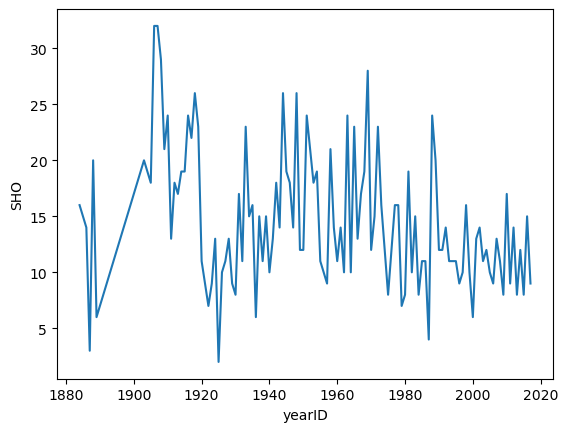

In [13]:
winners = teams[teams.WSWin == 'Y']
display(winners)
sns.lineplot(data=winners, x="yearID", y="SHO")

There appears to be no strong correlation between the number of shutouts that a team performs and their ability to win. This is likely because you can still win a game even if it isn't a shutout. However, it seems that it is rare for a teeam with few shutouts to win the world series. It also seems to me that the years between 1900 and 1920 generally had more shutouts if they won the world series. This would make it seem like the skill gap between the best and worst teams has been getting smaller, especially with how many more games teams play now than they used to.

<Axes: xlabel='balls/game', ylabel='winPercent'>

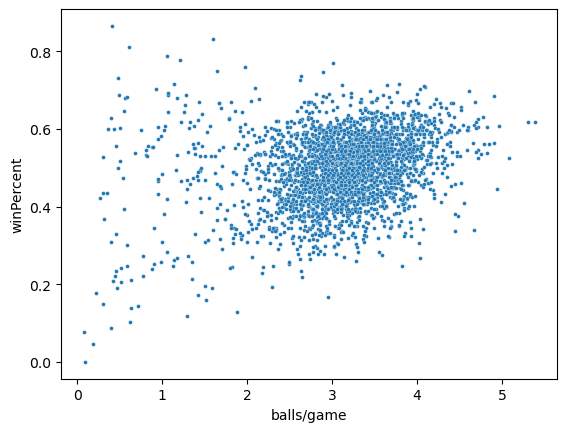

In [10]:
sns.scatterplot(x='balls/game', y='winPercent', data=walkteams, s=8)

## Max - Percentage of Successful Base Steal vs Percentage of Game Wins

In [17]:
teams = pd.read_csv('./data/core/Teams.csv')
teams.columns

stealTeams = teams[['CS', 'SB', 'G', 'W', 'yearID', 'teamID']] 
stealTeams = stealTeams.dropna()
stealTeams['stealAttempts'] = stealTeams.SB + stealTeams.CS
stealTeams['successfulStealAttemptsPercent'] = stealTeams.SB/stealTeams.stealAttempts
stealTeams['winPercent'] = stealTeams.W/stealTeams.G

<Axes: xlabel='successfulStealAttemptsPercent', ylabel='winPercent'>

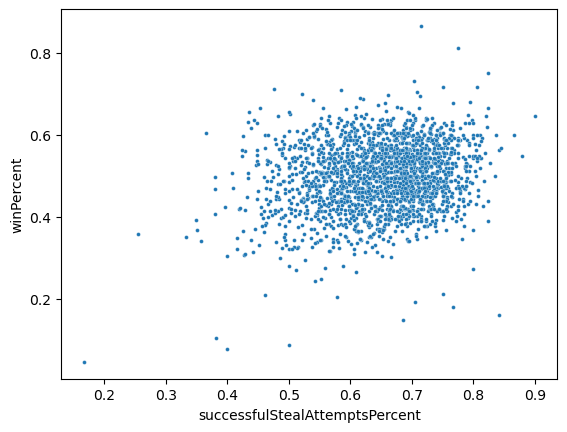

In [19]:
sns.scatterplot(x='successfulStealAttemptsPercent', y='winPercent', data=stealTeams, s=8)